In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VAR

## Price_1

### Price_1 6:3:1

In [56]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

In [57]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv')
df['Index'] = range(2680)

In [58]:
df = df[['Index', 'Price (VND)']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Index,Price (VND)
0,0,32202288.50
1,1,33607538.00
2,2,33923003.00
3,3,33628569.00
4,4,34000652.75


In [59]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [60]:
# 3. Huấn luyện mô hình VAR
model = VAR(train_data)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        42.01       42.01   1.748e+18       42.01
1       -13.32      -13.30   1.646e-06      -13.31
2       -10.10      -10.07   4.093e-05      -10.09
3       -13.43      -13.38   1.477e-06      -13.41
4       -12.60      -12.54   3.372e-06      -12.58
5       -14.67      -14.60   4.234e-07      -14.65
6       -12.41      -12.32   4.071e-06      -12.38
7       -10.93      -10.83   1.798e-05      -10.89
8      -15.41*     -15.30*  2.021e-07*     -15.37*
9       -11.39      -11.26   1.135e-05      -11.34
10      -11.45      -11.31   1.061e-05      -11.40
11      -12.69      -12.53   3.086e-06      -12.63
12      -10.49      -10.33   2.772e-05      -10.43
--------------------------------------------------


In [61]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [62]:
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jun, 2023
Time:                     03:57:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.7628
Nobs:                     1603.00    HQIC:                  -10.8092
Log likelihood:           4158.47    FPE:                1.96652e-05
AIC:                     -10.8367    Det(Omega_mle):     1.93981e-05
--------------------------------------------------------------------
Results for equation Index
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.272727              NAN              NAN             NAN
L1.Index               0.745455              NAN              NAN             NAN
L1.Price (VND)         0.000000         0.000000        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1545: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


In [63]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Index', 'Price (VND)']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Index', 'Price (VND)']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [64]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print([round(x[1],2) for x in y_next_30_days])

Predicted closing prices for the next 30 days:
[44304168.89, 44226092.19, 44165937.26, 44099499.11, 44032651.91, 43966786.86, 43901071.44, 43835578.68, 43770376.08, 43705439.79, 43640767.43, 43576360.5, 43512217.43, 43448336.99, 43384718.19, 43321359.96, 43258261.2, 43195420.87, 43132837.89, 43070511.21, 43008439.79, 42946622.56, 42885058.49, 42823746.54, 42762685.66, 42701874.84, 42641313.05, 42580999.25, 42520932.44, 42461111.6]


In [65]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 3768091.7211323753
Validation MAPE: 10.818700550135645
Validation MAE: 2172839.328211826
Testing RMSE: 6352238.055758362
Testing MAPE: 30.55383569550514
Testing MAE: 3807911.7602429665


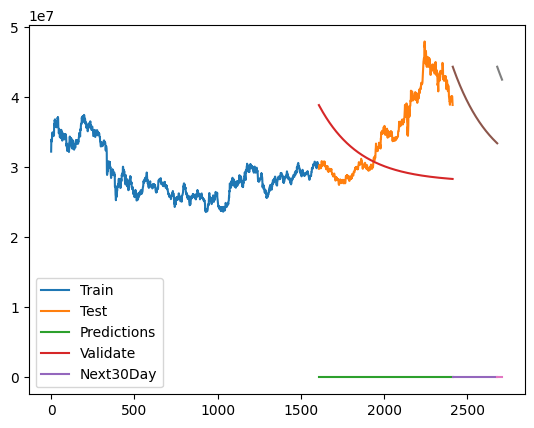

In [66]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price (VND)'])
plt.plot(test_data.index, test_data['Price (VND)'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price_1 7:2:1

In [67]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

In [68]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv')
df['Index'] = range(2680)

In [69]:
df = df[['Index', 'Price (VND)']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Index,Price (VND)
0,0,32202288.50
1,1,33607538.00
2,2,33923003.00
3,3,33628569.00
4,4,34000652.75


In [70]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [71]:
# 3. Huấn luyện mô hình VAR
model = VAR(train_data)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        42.32       42.33   2.397e+18       42.32
1       -12.15      -12.14   5.271e-06      -12.15
2       -14.07      -14.04   7.765e-07      -14.06
3       -12.23      -12.19   4.858e-06      -12.22
4       -11.19      -11.14   1.375e-05      -11.17
5       -13.11      -13.04   2.030e-06      -13.08
6       -11.63      -11.56   8.874e-06      -11.60
7      -16.48*     -16.40*  6.930e-08*     -16.45*
8       -15.27      -15.16   2.346e-07      -15.23
9       -15.99      -15.88   1.136e-07      -15.95
10      -11.00      -10.88   1.668e-05      -10.96
11      -11.77      -11.63   7.742e-06      -11.72
12      -13.03      -12.89   2.185e-06      -12.98
--------------------------------------------------


In [72]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [73]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Index', 'Price (VND)']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Index', 'Price (VND)']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [74]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print([round(x[1],2) for x in y_next_30_days])

Predicted closing prices for the next 30 days:
[44294989.22, 44225534.78, 44175924.02, 44097480.72, 44035324.71, 43978525.83, 43910490.33, 43843904.96, 43778552.73, 43712304.83, 43647016.15, 43582169.66, 43517167.16, 43452519.45, 43388202.96, 43324127.13, 43260366.28, 43196896.17, 43133693.96, 43070779.07, 43008148.69, 42945797.9, 42883728.5, 42821938.27, 42760425.16, 42699188.78, 42638227.8, 42577540.83, 42517126.79, 42456984.4]


In [75]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 3684178.1095076557
Validation MAPE: 10.69892515119579
Validation MAE: 2136172.5166365397
Testing RMSE: 6227212.19763793
Testing MAPE: 21.97041578996829
Testing MAE: 3708145.2777787647


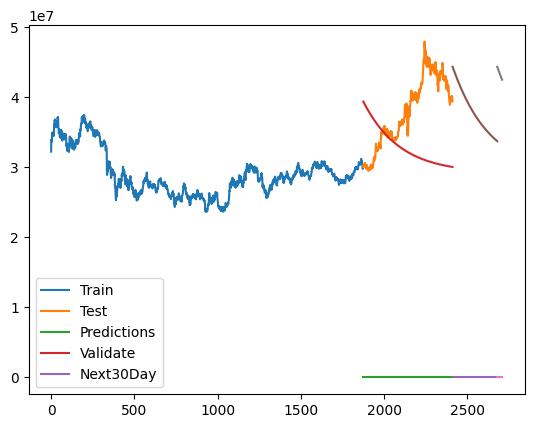

In [76]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price (VND)'])
plt.plot(test_data.index, test_data['Price (VND)'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price_1 8:1:1

In [77]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

In [78]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_1.csv')
df['Index'] = range(2680)

In [79]:
df = df[['Index', 'Price (VND)']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Index,Price (VND)
0,0,32202288.50
1,1,33607538.00
2,2,33923003.00
3,3,33628569.00
4,4,34000652.75


In [80]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [81]:
# 3. Huấn luyện mô hình VAR
model = VAR(train_data)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        42.93       42.94   4.415e+18       42.93
1       -14.34      -14.32   5.915e-07      -14.33
2       -15.13      -15.11   2.676e-07      -15.12
3       -12.58      -12.55   3.424e-06      -12.57
4       -12.50      -12.46   3.716e-06      -12.49
5       -14.39      -14.33   5.642e-07      -14.37
6      -16.14*     -16.07*  9.792e-08*     -16.11*
7       -13.58      -13.50   1.268e-06      -13.55
8       -12.45      -12.36   3.921e-06      -12.42
9       -11.54      -11.44   9.743e-06      -11.50
10      -13.22      -13.11   1.818e-06      -13.18
11      -14.12      -13.99   7.404e-07      -14.07
12      -15.32      -15.19   2.224e-07      -15.27
--------------------------------------------------


In [82]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [83]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Index', 'Price (VND)']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Index', 'Price (VND)']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [84]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print([round(x[1],2) for x in y_next_30_days])

Predicted closing prices for the next 30 days:
[44350314.37, 44322497.7, 44299982.34, 44273744.49, 44247669.89, 44221809.19, 44195980.4, 44170243.83, 44144601.44, 44119049.46, 44093588.55, 44068218.49, 44042938.93, 44017749.61, 43992650.24, 43967640.56, 43942720.28, 43917889.13, 43893146.83, 43868493.1, 43843927.67, 43819450.27, 43795060.62, 43770758.46, 43746543.51, 43722415.5, 43698374.16, 43674419.23, 43650550.44, 43626767.51]


In [85]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 1523332.560465045
Validation MAPE: 6.713666529466191
Validation MAE: 810965.6856688575
Testing RMSE: 3622752.5235783085
Testing MAPE: 11.178204490897757
Testing MAE: 2280883.04295722


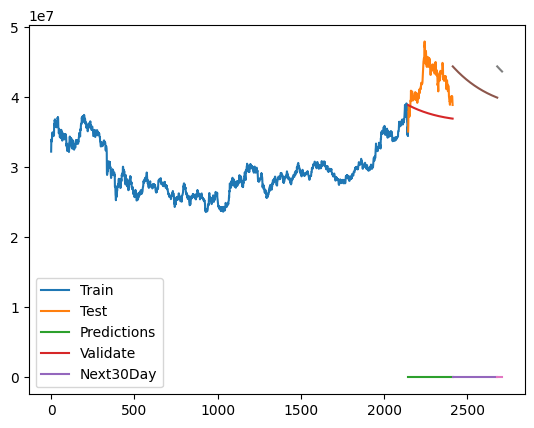

In [86]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Price (VND)'])
plt.plot(test_data.index, test_data['Price (VND)'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

## Price_2

### Price 2 6:3:1

In [87]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [88]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv')
df = df[['USO', 'GLD']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,USO,GLD
0,78.470001,84.860001
1,78.370003,85.570000
2,77.309998,85.129997
3,75.500000,84.769997
4,76.059998,86.779999


In [89]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [90]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['USO', 'GLD']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.28       12.29   2.157e+05       12.28
1        1.425      1.448*       4.160       1.434
2        1.421       1.459       4.140       1.435
3        1.413       1.466       4.107       1.433
4        1.403       1.471       4.065      1.428*
5        1.404       1.489       4.073       1.436
6        1.406       1.505       4.079       1.443
7        1.410       1.524       4.094       1.453
8        1.410       1.540       4.096       1.459
9        1.407       1.553       4.084       1.462
10       1.409       1.570       4.091       1.469
11       1.407       1.584       4.085       1.473
12      1.401*       1.592      4.059*       1.473
--------------------------------------------------


In [91]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [92]:
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jun, 2023
Time:                     03:57:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.59249
Nobs:                     1362.00    HQIC:                   1.47267
Log likelihood:          -4769.26    FPE:                    4.05922
AIC:                      1.40098    Det(Omega_mle):         3.91421
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.171399         0.206826            0.829           0.407
L1.y1          0.900273         0.028330           31.778           0.000
L1.y2          0.039763         0.018505            2.149           0.032
L2.y1          0.

In [93]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['USO', 'GLD']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['USO', 'GLD']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [94]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[ 14.37937035 122.79354914]
 [ 14.36386096 122.89432348]
 [ 14.53537971 123.26669155]
 [ 14.70964867 123.4889694 ]
 [ 14.88170913 123.59596364]
 [ 15.00278995 123.80389298]
 [ 15.17053594 123.95024943]
 [ 15.39814917 124.23839691]
 [ 15.4343522  124.43475223]
 [ 15.56556804 124.58756643]
 [ 15.72927624 124.89799614]
 [ 15.79426963 125.03376841]
 [ 15.91342625 125.21564014]
 [ 16.02030692 125.38719805]
 [ 16.1239037  125.55968476]
 [ 16.22484604 125.74862503]
 [ 16.33178728 125.92486671]
 [ 16.44245881 126.10411426]
 [ 16.52988327 126.26865012]
 [ 16.62584533 126.42702883]
 [ 16.72566661 126.60299935]
 [ 16.81431727 126.75860178]
 [ 16.90730738 126.92358833]
 [ 17.00035083 127.08548008]
 [ 17.09161621 127.24575297]
 [ 17.18202051 127.40608784]
 [ 17.27310293 127.5643724 ]
 [ 17.3639404  127.72237044]
 [ 17.45183102 127.87807253]
 [ 17.54023174 128.03218673]]


In [95]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 13.346662501852744
Validation MAPE: 30.221035424268848
Validation MAE: 12.798566717344798
Testing RMSE: 25.066153222406868
Testing MAPE: 81.81909943636101
Testing MAE: 22.861143983840037


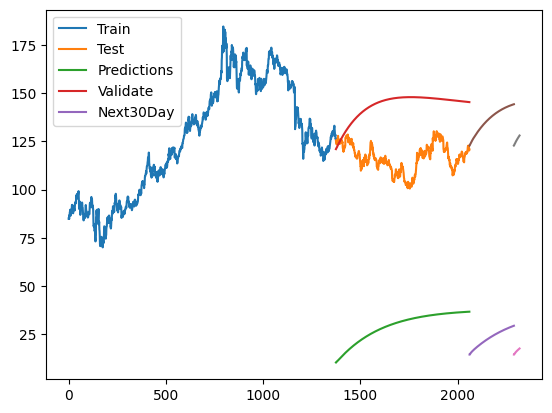

In [96]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['GLD'])
plt.plot(test_data.index, test_data['GLD'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price 2 7:2:1

In [97]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [98]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv')
df = df[['USO', 'GLD']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,USO,GLD
0,78.470001,84.860001
1,78.370003,85.570000
2,77.309998,85.129997
3,75.500000,84.769997
4,76.059998,86.779999


In [99]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [100]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['USO', 'GLD']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.14       12.14   1.868e+05       12.14
1        1.216      1.237*       3.375       1.224
2        1.211       1.244       3.356       1.223
3        1.204       1.251       3.333       1.222
4        1.195       1.255       3.302      1.217*
5        1.196       1.270       3.306       1.223
6        1.196       1.283       3.306       1.228
7        1.198       1.300       3.315       1.236
8        1.198       1.313       3.315       1.241
9        1.196       1.324       3.307       1.244
10       1.197       1.339       3.310       1.250
11       1.195       1.350       3.303       1.253
12      1.189*       1.358      3.283*       1.251
--------------------------------------------------


In [101]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [102]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['USO', 'GLD']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['USO', 'GLD']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [103]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[ 14.34615315 122.75709182]
 [ 14.29309532 122.78037892]
 [ 14.42128538 123.05873242]
 [ 14.55974945 123.23215985]
 [ 14.68535447 123.26472036]
 [ 14.76701444 123.39972809]
 [ 14.899138   123.51337536]
 [ 15.07777248 123.75574911]
 [ 15.07786846 123.90648975]
 [ 15.16659504 124.00830985]
 [ 15.28921475 124.25038575]
 [ 15.31607265 124.33686136]
 [ 15.39626623 124.46895255]
 [ 15.46631707 124.59890086]
 [ 15.5286609  124.72237854]
 [ 15.59238165 124.86080104]
 [ 15.66184113 124.99202775]
 [ 15.73343051 125.12096687]
 [ 15.78466972 125.23788052]
 [ 15.84275968 125.35089089]
 [ 15.90535508 125.47958477]
 [ 15.95787287 125.59203319]
 [ 16.01445355 125.71140626]
 [ 16.07160351 125.82899066]
 [ 16.12643711 125.94444279]
 [ 16.18131374 126.0608013 ]
 [ 16.23708632 126.17667357]
 [ 16.29247578 126.29178421]
 [ 16.34574181 126.40536642]
 [ 16.3993704  126.51785898]]


In [104]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 10.061894555418359
Validation MAPE: 25.773913645826376
Validation MAE: 9.682092892648281
Testing RMSE: 19.341779983301603
Testing MAPE: 60.35261108823909
Testing MAE: 17.206373918801113


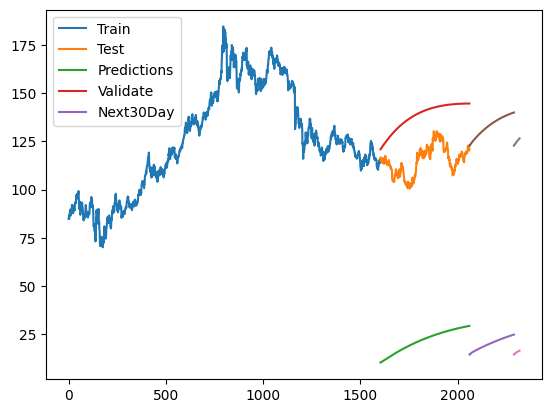

In [105]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['GLD'])
plt.plot(test_data.index, test_data['GLD'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price 2 8:1:1

In [106]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [107]:
# 2. Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_2.csv')
df = df[['USO', 'GLD']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,USO,GLD
0,78.470001,84.860001
1,78.370003,85.570000
2,77.309998,85.129997
3,75.500000,84.769997
4,76.059998,86.779999


In [108]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [109]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['USO', 'GLD']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.26       12.27   2.121e+05       12.27
1        1.030      1.049*       2.802       1.037
2        1.025       1.055       2.786       1.036
3        1.018       1.061       2.768       1.034
4        1.009       1.064       2.744      1.029*
5        1.010       1.077       2.746       1.035
6        1.010       1.089       2.746       1.039
7        1.013       1.103       2.753       1.046
8        1.013       1.115       2.753       1.051
9        1.010       1.125       2.746       1.053
10       1.011       1.138       2.748       1.058
11       1.008       1.147       2.740       1.059
12      1.003*       1.154      2.725*       1.058
--------------------------------------------------


In [110]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [111]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['USO', 'GLD']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['USO', 'GLD']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [112]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[ 14.32781496 122.70853759]
 [ 14.25427398 122.71268457]
 [ 14.35405369 122.91898594]
 [ 14.46311332 123.02023228]
 [ 14.55367005 123.01735907]
 [ 14.60602431 123.11148296]
 [ 14.70543972 123.1688015 ]
 [ 14.84565202 123.34242493]
 [ 14.82290562 123.4505054 ]
 [ 14.88144819 123.50813602]
 [ 14.97329999 123.68962421]
 [ 14.97508072 123.73389419]
 [ 15.02384378 123.81673817]
 [ 15.0662249  123.90289629]
 [ 15.10095434 123.98255212]
 [ 15.13658552 124.07402705]
 [ 15.17734834 124.16019747]
 [ 15.22016949 124.24370254]
 [ 15.244971   124.31799003]
 [ 15.27551129 124.38853882]
 [ 15.31059409 124.47288521]
 [ 15.33649435 124.54352464]
 [ 15.36578018 124.61958561]
 [ 15.39601678 124.69515705]
 [ 15.42405384 124.7687365 ]
 [ 15.45225971 124.84314843]
 [ 15.48136194 124.91771303]
 [ 15.51015422 124.99160956]
 [ 15.53723428 125.06446286]
 [ 15.56466331 125.13658428]]


In [113]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 6.993068553721901
Validation MAPE: 20.894860699520066
Validation MAE: 6.753210587385148
Testing RMSE: 9.444542345457721
Testing MAPE: 19.978482785261633
Testing MAE: 6.799760566375205


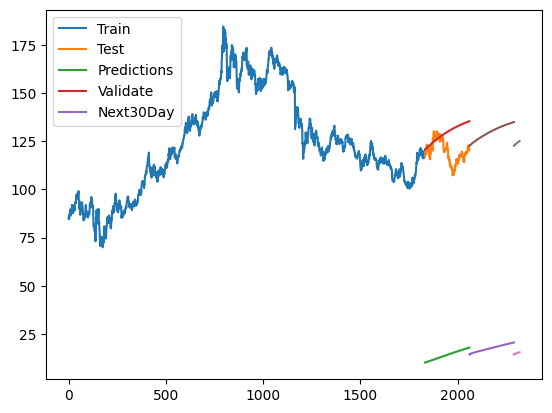

In [114]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['GLD'])
plt.plot(test_data.index, test_data['GLD'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

## Price_3

### Price 3 6:3:1

In [115]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [116]:
# 2. Đọc file dữ liệu giá vàng và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv')
df = df[['Open', 'Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Open,Close
0,1292.699951,1290.699951
1,1286.900024,1273.300049
2,1282.900024,1271.400024
3,1278.599976,1292.900024
4,1286.500000,1265.599976


In [117]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [118]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['Open', 'Close']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.85       14.86   2.818e+06       14.86
1        8.576      8.605*       5305.       8.587
2        8.566       8.614       5252.      8.584*
3        8.573       8.639       5287.       8.598
4        8.576       8.662       5304.       8.609
5        8.577       8.681       5306.       8.616
6        8.547       8.670       5150.       8.594
7        8.544       8.686       5135.       8.598
8       8.544*       8.705      5134.*       8.605
9        8.549       8.729       5163.       8.618
10       8.550       8.749       5165.       8.625
11       8.554       8.772       5186.       8.636
12       8.553       8.790       5183.       8.643
--------------------------------------------------


In [119]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [120]:
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jun, 2023
Time:                     03:57:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.69710
Nobs:                     1048.00    HQIC:                   8.59731
Log likelihood:          -7413.15    FPE:                    5096.77
AIC:                      8.53636    Det(Omega_mle):         4935.36
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -4.276264         1.872444           -2.284           0.022
L1.y1        -0.117371         0.034161           -3.436           0.001
L1.y2         1.002654         0.017839           56.206           0.000
L2.y1        -0.030335

In [121]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Open', 'Close']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Open', 'Close']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [122]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[2016.76301799 2018.95423492]
 [2022.94821527 2022.85602824]
 [2025.9729742  2026.37669015]
 [2027.37436784 2025.57122007]
 [2028.1279941  2024.5656782 ]
 [2024.85064967 2024.38223059]
 [2026.55456828 2023.72036353]
 [2025.91661149 2024.51543714]
 [2027.203589   2026.32121257]
 [2029.43846291 2028.72985188]
 [2031.77487458 2031.46939178]
 [2034.47578792 2033.78603922]
 [2036.90111245 2036.61844714]
 [2039.52983903 2038.98055845]
 [2041.93379069 2041.42215108]
 [2044.29512017 2043.70434875]
 [2046.52428533 2045.8430097 ]
 [2048.7145441  2048.01376389]
 [2050.83451494 2050.14013288]
 [2053.0152186  2052.29178773]
 [2055.16018887 2054.45851716]
 [2057.34876436 2056.64447872]
 [2059.55573144 2058.85885656]
 [2061.7766201  2061.09547769]
 [2064.02741955 2063.33813583]
 [2066.27699875 2065.59749012]
 [2068.54178867 2067.85371184]
 [2070.80602559 2070.11837889]
 [2073.07563173 2072.38438206]
 [2075.34783924 2074.65203574]]


In [123]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 418.4722335253069
Validation MAPE: 18.591689921044374
Validation MAE: 414.4035376975039
Testing RMSE: 751.385389207666
Testing MAPE: 33.15671790942356
Testing MAE: 603.0980169420312


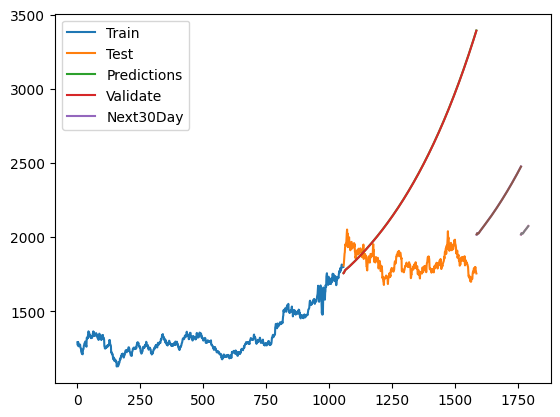

In [124]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price 3 7:2:1

In [125]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [126]:
# 2. Đọc file dữ liệu giá vàng và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv')
df = df[['Open', 'Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Open,Close
0,1292.699951,1290.699951
1,1286.900024,1273.300049
2,1282.900024,1271.400024
3,1278.599976,1292.900024
4,1286.500000,1265.599976


In [127]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [128]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['Open', 'Close']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.98       15.99   8.729e+06       15.99
1        9.047      9.072*       8492.      9.056*
2        9.045       9.086       8472.       9.060
3        9.048       9.106       8498.       9.070
4        9.046       9.121       8483.       9.074
5        9.046       9.138       8485.       9.081
6       9.042*       9.151      8454.*       9.083
7        9.048       9.173       8498.       9.095
8        9.051       9.194       8529.       9.105
9        9.055       9.214       8558.       9.115
10       9.049       9.225       8510.       9.115
11       9.055       9.247       8558.       9.127
12       9.053       9.263       8547.       9.132
--------------------------------------------------


In [129]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [130]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Open', 'Close']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Open', 'Close']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [131]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[2014.17606009 2014.47681453]
 [2016.37122373 2015.83105856]
 [2016.70666311 2015.81614779]
 [2015.29178082 2012.00461894]
 [2012.91862444 2010.25940159]
 [2010.08043585 2008.060601  ]
 [2008.69688597 2007.78502537]
 [2008.440088   2008.01642143]
 [2008.6306864  2008.22441398]
 [2009.03683329 2008.67689119]
 [2009.36535056 2008.82662228]
 [2009.52866367 2008.8022423 ]
 [2009.46181786 2008.64991529]
 [2009.2806415  2008.42217533]
 [2009.06438423 2008.22277517]
 [2008.85724608 2008.04581241]
 [2008.69111166 2007.91044024]
 [2008.5620865  2007.80555895]
 [2008.45919542 2007.70857327]
 [2008.36495421 2007.6132227 ]
 [2008.26799027 2007.51025624]
 [2008.16399332 2007.39973263]
 [2008.05230084 2007.28419644]
 [2007.93575028 2007.1659537 ]
 [2007.81742064 2007.04812414]
 [2007.69957391 2006.9316152 ]
 [2007.58330233 2006.81669243]
 [2007.46860731 2006.70301023]
 [2007.35501572 2006.58987041]
 [2007.24191244 2006.47685386]]


In [132]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 223.67456809295092
Validation MAPE: 9.470435401992797
Validation MAE: 189.75690774450672
Testing RMSE: 77.02175861207738
Testing MAPE: 3.0701372079424485
Testing MAE: 57.31276215224406


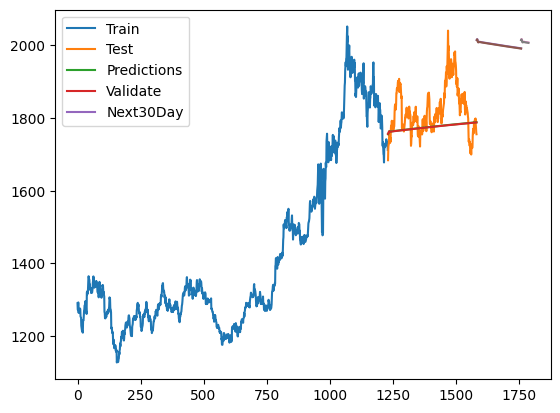

In [133]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

### Price 3 8:1:1

In [134]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR

In [135]:
# 2. Đọc file dữ liệu giá vàng và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/drive/MyDrive/Study/IS403.N22.HTCL/final project/DATASET/Gold_Price_3.csv')
df = df[['Open', 'Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df.head()

,Open,Close
0,1292.699951,1290.699951
1,1286.900024,1273.300049
2,1282.900024,1271.400024
3,1278.599976,1292.900024
4,1286.500000,1265.599976


In [136]:
# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [137]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data[['Open', 'Close']])

# 3. Huấn luyện mô hình VAR
model = VAR(y_train)

# Tìm ra số lượng lag tối ưu cho mô hình
lag_order = model.select_order(maxlags=12)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        16.14       16.15   1.024e+07       16.14
1        9.052      9.074*       8533.      9.060*
2        9.051       9.089       8531.       9.066
3        9.053       9.105       8541.       9.072
4        9.052       9.120       8539.       9.078
5        9.054       9.136       8549.       9.084
6       9.048*       9.146      8501.*       9.084
7        9.053       9.165       8542.       9.095
8        9.056       9.184       8571.       9.104
9        9.060       9.203       8606.       9.114
10       9.058       9.215       8584.       9.117
11       9.063       9.236       8629.       9.128
12       9.063       9.250       8627.       9.133
--------------------------------------------------


In [138]:
# Fit mô hình với số lượng lag tối ưu
model_fit = model.fit(maxlags=lag_order.aic, ic='aic')

In [139]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data[['Open', 'Close']])
y_pred = model_fit.forecast(y_test, len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data[['Open', 'Close']])
y_pred_val =  model_fit.forecast(y_val, len(y_val))

In [140]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(df.values, 30)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[[2014.0540238  2015.17224618]
 [2016.53110567 2015.77207146]
 [2016.28027316 2016.10755469]
 [2015.09815184 2012.69875844]
 [2013.29291594 2011.3264327 ]
 [2010.72996034 2009.32634161]
 [2009.58046178 2009.02888257]
 [2009.34030911 2009.288443  ]
 [2009.4794254  2009.34844833]
 [2009.76953393 2009.6999308 ]
 [2009.98442772 2009.8188873 ]
 [2010.12359441 2009.79504769]
 [2010.07015728 2009.69781667]
 [2009.93798897 2009.52429343]
 [2009.784922   2009.38191236]
 [2009.63166124 2009.24845292]
 [2009.50652506 2009.13758628]
 [2009.40198683 2009.05137647]
 [2009.31514884 2008.96743005]
 [2009.23455004 2008.886695  ]
 [2009.15224729 2008.80200447]
 [2009.06693723 2008.71273609]
 [2008.97732212 2008.6213495 ]
 [2008.88503326 2008.52786392]
 [2008.79171454 2008.43461433]
 [2008.69843347 2008.34196901]
 [2008.6059263  2008.24998523]
 [2008.51415717 2008.15873596]
 [2008.42295686 2008.06776192]
 [2008.33206879 2007.97693692]]


In [141]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

valid_rmse = np.sqrt(MSE(y_pred_val, y_val))
test_rmse = np.sqrt(MSE(y_test, y_pred))
valid_mape = MAPE(y_pred_val, y_val)*100
test_mape = MAPE(y_test, y_pred)*100
valid_mae = MAE(y_pred_val, y_val)
test_mae = MAE(y_test, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Validation MAE:', valid_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Validation RMSE: 225.29331971502666
Validation MAPE: 9.559403008141775
Validation MAE: 191.72303992129423
Testing RMSE: 102.55764721178159
Testing MAPE: 4.423825329458529
Testing MAE: 83.40303680936324


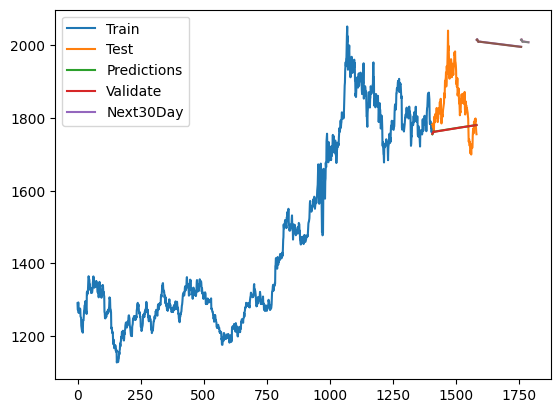

In [142]:
# 8.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()